# Stacked ensemble attempt

In this notebook I use ML-Ensemble to create a stacked ensemble using classifiers from the work described in the "Final_Submission" notebook.

Work towards the end of the notebook is unfinished.  At l

In [1]:
# Import libraries.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

from mlens.ensemble import SuperLearner

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning) 

[MLENS] backend: threading


In [2]:
# Import data files from Kaggle.
DATA_PATH = './data/extracted'
dfs_raw = {}
dfs = {}
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        dfs[file.split('.')[0]] = pd.read_csv(f'{DATA_PATH}/{file}')
        print(file)

age_gender_bkts.csv
countries.csv
sample_submission_NDF.csv
sessions.csv
test_users.csv
train_users_2.csv


In [94]:
def transformToDatetime(series_input):
    return pd.to_datetime(series_input,format='%Y%m%d%H%M%S', errors='coerce')

#Function to bucket ages prior to one-hot encoding
def getAgeBucket(df_input):
    z = df_input.age
    z = pd.to_numeric(df_input.age, errors='coerce')
    return pd.cut(z,
                    [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94,99,10000],
                    labels=['0-4', '5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                            '50-54', '55-59','60-64', '65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'],
                    include_lowest=True)

def getCountryForAge(df_input):
    z = df_input.age
    z = pd.to_numeric(df_input.age, errors='coerce')

#Add month and year features
def getYearFirstActive(df_input):
    return pd.Series(transformToDatetime(df_input.timestamp_first_active).dt.year, index=df_input.index)

def getMonthFirstActive(df_input):
    return pd.Series(transformToDatetime(df_input.timestamp_first_active).dt.month, index=df_input.index)

def getSeason(df_input):
    season = pd.Series(transformToDatetime(df_input.timestamp_first_active).dt.month, index=df_input.index)
    season[season.isin([12, 1, 2])] = 'Winter'
    season[season.isin([3, 4, 5])] = 'Spring'
    season[season.isin([6, 7, 8])] = 'Summer'
    season[season.isin([9, 10, 11])] = 'Fall'
    return season

def getSessionActivityCount(df_input):
    return dfs['sessions'].groupby(['user_id']).size().reset_index(name='counts').set_index('user_id')


    
# add features to training and test data: stateful data mutations (ew)
# attempted to use pipelines, column_transformer, function_transformer, feature_union
# the features can't be arbitrarily included since function_transformer and column_transformer return ndarray's instead of dataframes

def add_features(df_input):
    engineered_data = df_input
    engineered_data['age_bucket'] = getAgeBucket(engineered_data)
    engineered_data['first_active_year'] = getYearFirstActive(engineered_data)
    engineered_data['first_active_month'] = getMonthFirstActive(engineered_data)
    engineered_data['season'] = getSeason(engineered_data)
    engineered_data['activity_count'] = getSessionActivityCount(engineered_data)
    return engineered_data

In [95]:
all_train_data = add_features(dfs["train_users_2"].iloc[:, 0:-1].copy().set_index('id'))
all_train_labels = dfs["train_users_2"].iloc[:, -1:]
all_test_data = add_features(dfs["test_users"].copy().set_index('id'))

In [96]:
# Set train/dev split to 0.04685/0.95315 to give train size of 10k.  0.04685 = 10000/213451
test_size = .5

le = LabelEncoder()
encoded_labels = le.fit_transform(all_train_labels.values.ravel())

# Use (train_test_split) to randomize train_users_2 before splitting into train/dev.
train_data, dev_data, train_labels, dev_labels = train_test_split(all_train_data, encoded_labels, test_size=test_size, random_state=42)

# Final test data for Kaggle submission.
test_data = all_test_data

In [191]:
def create_balanced_training_set():
    countries = np.unique(encoded_labels)
    z = train_data.copy()
    z['dest'] = pd.Series(train_labels, index=z.index)
    picks = round(len(train_data)/len(countries))
    rx = []
    for destination in countries:
        options = z[z['dest'] == destination].index
        ff = np.random.choice(options, picks)
        rx.append(z.ix[ff])
    
    balanced_data = pd.concat(rx) 
    return balanced_data.iloc[:, 0:-1], balanced_data.iloc[:, -1:].values.ravel()

balanced_train_data, balanced_train_labels = create_balanced_training_set()

In [97]:
# Create Preprocessor pipeline.
def create_preprocessor_pipeline():
    
    categorical_columns_to_process = [
        'gender',
        'signup_method',
        'signup_flow',
        'language',
        'affiliate_channel',
        'affiliate_provider',
        'first_affiliate_tracked',
        'signup_app',
        'first_device_type',
        'first_browser',
        'age_bucket',
        'season',
        'first_active_month',
        'first_active_year'
    ]
    
    numerical_columns_to_process = [
        'activity_count'
    ]
    
    return make_column_transformer(
        (categorical_columns_to_process,
         make_pipeline(
             SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="unknown"),
             OneHotEncoder(handle_unknown='ignore')
         )
        ),
        (numerical_columns_to_process,
         make_pipeline(
             SimpleImputer(missing_values=np.nan, strategy='mean'),
             StandardScaler()
         )
        ),
        remainder='drop'
    )

preprocessor = create_preprocessor_pipeline()

In [ ]:
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
#score_dict['XG Boost Full Training Set'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [185]:
def stacking(propagate=None, proba=None):
    seed = 142
    
    # --- Build ---
    # Passing a scoring function will create cv scores during fitting
    # the scorer should be a simple function accepting to vectors and returning a scalar
    ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)
    pf = False
    if propagate:
        pf = list(range(preprocessor.fit_transform(balanced_train_data).shape[1]))
    # Build the first layer
    ensemble.add([
        RandomForestClassifier(random_state=seed,n_estimators=300, max_depth=10, class_weight='balanced'),
        XGBClassifier()
    ],
        #preprocessing=[preprocessor],
        propagate_features=pf,
        proba=proba)

    # Attach the final meta estimator
    ensemble.add_meta(LogisticRegression())

    # --- Use ---

    # Fit ensemble
    pipeline = make_pipeline(preprocessor, ensemble)
    pipeline.fit(balanced_train_data, balanced_train_labels)
    
    dev_pred = pipeline.predict(dev_data)
    accuracy = accuracy_score(dev_pred, dev_labels)

    #ensemble.fit(train_data, train_labels)

    # Predict
    #preds = ensemble.predict(dev_data)
    print('Accuracy: ',accuracy)
    print(classification_report(dev_pred, dev_labels))
    print("Fit data:\n%r" % ensemble.data)
    #print("Prediction score: %.3f" % accuracy_score(preds, dev_labels))

stacking(False,False)
stacking(True,True)


Fitting 2 layers
Processing layer-1             done | 00:02:15
Processing layer-2             done | 00:00:01
Fit complete                        | 00:02:16

Predicting 2 layers


c:\users\christmi\data-sci\common\lib\site-packages\mlens\parallel\_base_functions.py:313: ParameterChangeWarning: Parameter value ('multi:softprob') has changed since model was fitted ('binary:logistic').
  (lpar, rpar), ParameterChangeWarning)


Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:08
Accuracy:  0.06503569889249106
              precision    recall  f1-score   support

         0.0       0.13      0.00      0.01      9976
         1.0       0.01      0.01      0.01       997
         2.0       0.08      0.01      0.01      6914
         3.0       0.19      0.01      0.01     39577
         4.0       0.13      0.03      0.06      9820
         5.0       0.00      0.00      0.00         0
         6.0       0.18      0.02      0.03     14465
         7.0       0.08      0.47      0.14     11171
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00       180
        10.0       0.00      0.00      0.00         0
        11.0       0.16      0.06      0.08     13626

   micro avg       0.07      0.07      0.07    106726
   macro avg       0.08      0.05      0.03    106726
weighted avg    

c:\users\christmi\data-sci\common\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\christmi\data-sci\common\lib\site-packages\mlens\parallel\_base_functions.py:313: ParameterChangeWarning: Parameter value ('multi:softprob') has changed since model was fitted ('binary:logistic').
  (lpar, rpar), ParameterChangeWarning)



Fitting 2 layers
Processing layer-1             

c:\users\christmi\data-sci\common\lib\site-packages\mlens\parallel\_base_functions.py:226: MetricWarning: [randomforestclassifier.0.1] Could not score randomforestclassifier. Details:
ValueError("Classification metrics can't handle a mix of multiclass and continuous-multioutput targets")
  (name, inst_name, exc), MetricWarning)
c:\users\christmi\data-sci\common\lib\site-packages\mlens\parallel\_base_functions.py:226: MetricWarning: [randomforestclassifier.0.2] Could not score randomforestclassifier. Details:
ValueError("Classification metrics can't handle a mix of multiclass and continuous-multioutput targets")
  (name, inst_name, exc), MetricWarning)
c:\users\christmi\data-sci\common\lib\site-packages\mlens\parallel\_base_functions.py:226: MetricWarning: [xgbclassifier.0.2] Could not score xgbclassifier. Details:
ValueError("Classification metrics can't handle a mix of multiclass and continuous-multioutput targets")
  (name, inst_name, exc), MetricWarning)
c:\users\christmi\data-sci\c

done | 00:02:23


IndexError: index (181) out of range

In [35]:
dev_labels.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

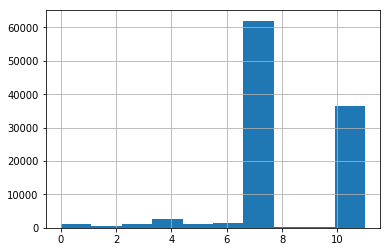

In [37]:
pd.Series(dev_labels).hist()

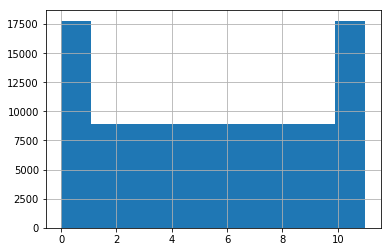

In [192]:
pd.Series(balanced_train_labels).hist()